# 文献真的指数增长么？

## 方法
查找世界、中国、美国、日本、英国1900年以来的SCI论文数，并作出每个国家的增长趋势，并利用回归分析求出论文数量对时间的回归模型

## 步骤
先在 wos 中检索并导出全世界和各国的 SCI 论文数为 csv 文件，再用 julia 语言进行回归分析

### 数据准备
1. 在wos中输入如下检索式![](文献指数增长/img/2022-09-23-23-05-51.png)
2. 点击“检索”按钮，进入检索结果页面![](文献指数增长/img/2022-09-23-23-35-25.png)
3. 点击“分析检索结果”按钮，在分析结果页选择出版年，并下载全世界的 SCI 论文数据表 WORLD.csv ![](文献指数增长/img/2022-09-24-13-03-05.png)
4. 回到步骤 2 的检索结果页面，在左侧导航栏“国家地区”处点击“全部查看”按钮，进入过滤国家地区页面，分别勾选 CHINA、USA、JAPAN、ENGLAND[](文献指数增长/img/2022-09-24-13-12-32.png)
5. 分别重复步骤 3，下载各国数据表，并命名为国名.csv
6. 将以上数据表放在“文献指数增长”目录下
   
### 回归分析

In [264]:
# 安装环境
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating environment at `c:\Users\oflg\Documents\Code\ucas\信息计量学及其应用\Project.toml`

使用 MLJ 机器学习包等

In [265]:
using MLJ
using CSV
using DataFrames
using Plots

获取目录下各数据文件名

In [266]:
root = dirname(@__FILE__)
path = joinpath(root, "文献指数增长", "data")
filenames = readdir(path)

5-element Vector{String}:
 "CHINA.csv"
 "ENGLAND.csv"
 "JAPAN.csv"
 "USA.csv"
 "WORLD.csv"

查看各数据散点图

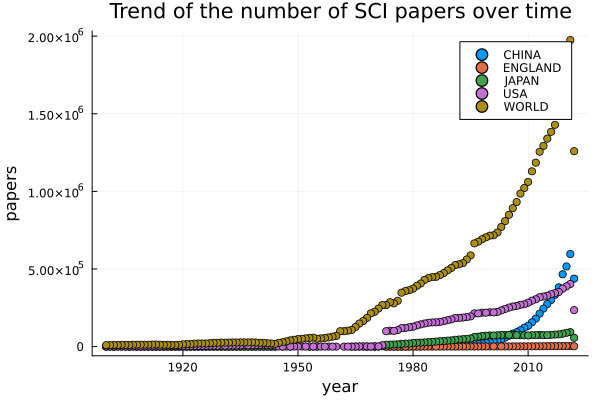

In [267]:
# GR()
p = plot(title="Trend of the number of SCI papers over time", xlabel="year", ylabel="papers");

for filename in filenames
    filepath = joinpath(path, filename)
    df = CSV.read(filepath, DataFrame)
    X1, y1 = df[!, :出版年], df[!, :记录数]
    plot!(p, X1, y1, seriestype=:scatter, label=replace(filename, ".csv" => ""))
end

p

选取并查看全世界（去除2022年）的数据

In [268]:
df = CSV.read(joinpath(path, "WORLD.csv"), DataFrame)
subset!(df, :出版年 => x -> x .!= 2022)
select!(df, Not(:"42,818,117的百分位"))
first(df, 3)

,出版年,记录数
,Int64,Int64
1,2021,1974687
2,2020,1808829
3,2019,1665368


In [269]:
schema(df)

┌────────┬──────────┬───────┐
│ names  │ scitypes │ types │
├────────┼──────────┼───────┤
│ 出版年 │ Count    │ Int64 │
│ 记录数 │ Count    │ Int64 │
└────────┴──────────┴───────┘


查看到散点图符合指数函数，将论文记录数取对数，再进行回归分析

In [270]:
#  X, y = unpack(df, ==(:记录数); rng=123);

X = select(df, :出版年)
y = log.(df.记录数)

coerce!(X, Count => Continuous)
schema(X)

┌────────┬────────────┬─────────┐
│ names  │ scitypes   │ types   │
├────────┼────────────┼─────────┤
│ 出版年 │ Continuous │ Float64 │
└────────┴────────────┴─────────┘


使用 LinearRegressor 线性回归分析模型

In [271]:
LinearRegressor=@load LinearRegressor pkg=MLJLinearModels
lr = LinearRegressor();

import MLJLinearModels ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main C:\Users\oflg\.julia\packages\MLJModels\9IVqK\src\loading.jl:159


构建机器，进行回归

In [272]:
m1 = machine(lr,X,y)
fit!(m1, verbosity = 0);

取出回归参数并作图

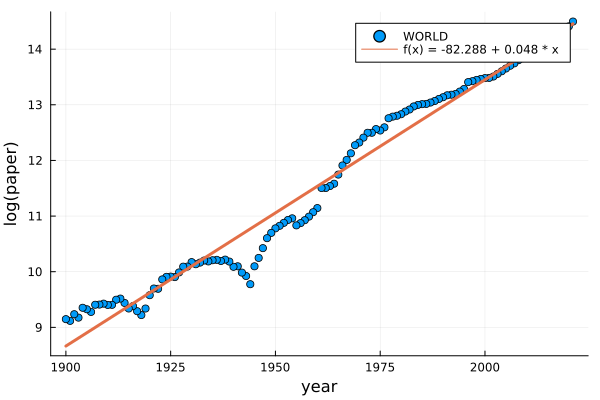

In [273]:
function fitted_linear_func(mach)
    θ̂ = fitted_params(mach)
    θ̂₀ = θ̂.intercept
    θ̂₁ = θ̂.coefs[1][2]
    f(x) = θ̂₀ + θ̂₁ * x
end;

begin
    scatter(X.出版年,y,
        xlabel="year",
        ylabel="log(paper)",
        label="WORLD")
    plot!(fitted_linear_func(m1), label="f(x) = $(round(θ̂₀,digits=3)) + $(round(θ̂₁,digits=3)) * x", w=3)
end

In [274]:
fitted_params(m1)

(coefs = [:出版年 => 0.04786950806933184],
 intercept = -82.28806678087484,)

计算均方根误差

In [275]:
rmse(predict(m1), y)

0.2928959245660408

## 结论
文献确实指数增长